## 0) 데이터 전처리
* Baseline코드에서 사용했던 전처리 방식을 그대로 사용
* index column은 학습에 관련이 없으니 제거

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

train = pd.read_csv("../data/train.csv")                            #r*c = 20000*20, test와 달리 credit이라는 column을 갖고 있고, 이 값을 예측
test = pd.read_csv("../data/test.csv")                              #10000*19. train으로 학습시키고 test데이터를 입력으로 넣어서 credit을 예측
sample_submission = pd.read_csv("../data/sample_submission.csv")    #예측값은 sample_submission과 형태가 같아야 함.

In [2]:
data = pd.concat([train, test], axis=0)    # train데이터 밑에 test데이터가 붙음. test에는 credit이 없으므로, 결측치(NaN)형태로 저장됨
# 실제로는 결측치를 완전히 날리는건 좋지 않지만, 1회 출제용으로 사용하기때문에 완전히 날림
data = data.drop("occyp_type", axis=1) # occyp_type column을 지움. axis : occyp_type이 row에 있는지 column에 있는지 알려줌. 1이면 column

In [3]:
unique_len = data.apply(lambda x : len(x.unique()))  # 각 column별로 unique()를 수행하여, 그 길이를 반환. 즉, 모든 column의 요소의 개수를 출력
group_1 = unique_len[unique_len <= 2].index   # 요소의 값이 2개 이하인 column들의 이름을 추출
group_2 = unique_len[(unique_len > 2) & (unique_len <= 10)].index
group_3 = unique_len[(unique_len > 10)].index

In [4]:
data['gender'] = data['gender'].replace(['F','M'], [0, 1])   # F를 0으로, M을 1로 교체
data['car'] = data['car'].replace(['N', 'Y'], [0, 1])
data['reality'] = data['reality'].replace(['N', 'Y'], [0,1])

In [5]:
data.loc[data['child_num']>2, 'child_num'] = 2  # child_num>2인 child_num column을 가져와서 2로 바꿈
data[group_2].apply(lambda x : len(x.unique()))
label_encoder = preprocessing.LabelEncoder() # categorical 변수(문자로 되어있는 변수)들을 숫자로 인코딩해주는 함수
set(label_encoder.fit_transform(data['income_type'])) # income_type column에서 각 요소들을 숫자로 바꿔줌. fit_transform이 배열을 반환해서 unique()대신 set을 사용
data['income_type'] = label_encoder.fit_transform(data['income_type'])
data['edu_type'] = label_encoder.fit_transform(data['edu_type'])
data['family_type'] = label_encoder.fit_transform(data['family_type'])
data['house_type'] = label_encoder.fit_transform(data['house_type'])

In [6]:
counts, bin_dividers = np.histogram(data['income_total'], bins=7) # 연속형 변수를 입력으로 받아 몇 개의 구간으로 나눌지 설정해줌. 각 구간들의 분절점(나누는 기준) 및 구간별 요소의 개수를 출력해줌
data['income_total'] = pd.factorize(pd.cut(data['income_total'], bins = bin_dividers, include_lowest=True, labels=[0,1,2,3,4,5,6]))[0] # pd.cut의 반환 데이터 타입은 category이기 때문에, series타입(int형 배열)으로 바꿔주는 작업을 거쳐야 함
#위의 과정을 함수로 만듬
def make_bin(array, N):
    array = -array      #DAYS_BIRTH등의 column은 음수이기 때문에 양수로 바꿔줌
    _, bin_dividers = np.histogram(array, bins = N)       # 여기선 counts 변수를 사용하지 않을 것이기 때문에 사용하지 않는다는 의미로 _로 설정.
    cut_categories = pd.cut(array, bin_dividers, labels = [i for i in range(N)], include_lowest=True)
    bined_array = pd.factorize(cut_categories)[0]
    return bined_array
data['DAYS_BIRTH'] = make_bin(data['DAYS_BIRTH'], 10)
data['DAYS_EMPLOYED'] = make_bin(data['DAYS_EMPLOYED'], 10)
data['begin_month'] = make_bin(data['begin_month'], 10)

In [7]:
data=data.drop('index', axis=1)
train = data[:-10000]   # train에 해당하는 값
test = data[-10000:]   #test에 해당하는 값
train_x = train.drop("credit", axis = 1) # credit은 출력값이고, credit을 제외한 값들이 모델의 입력값이므로 column들 중(axis =1) credit을 찾아 없앰.
train_y = train['credit']               # 모델의 출력이 credit
test_x = test.drop("credit", axis=1)        # data라는 dataframe을 만들면서 test set에 없던 credit이라는 column이 생겼으므로, 이를 다시 제거

## 1) RandomForestClassifier

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

In [11]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
predict = clf.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss = log_loss(y_val_onehot, predict)
print(logloss)

1.466047343279552


### 1_1) 하이퍼파라미터 조정

In [26]:
rf_param_grid = {
    'n_estimators' : [100, 200],
    'max_depth' : [8, 10, 12],
    'min_samples_leaf' : [3, 5, 7],
    'min_samples_split' : [3, 4, 5]
}

In [27]:
from sklearn.model_selection import GridSearchCV

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

clf = RandomForestClassifier()
clf_grid = GridSearchCV(clf, param_grid=rf_param_grid, scoring="accuracy", n_jobs=-1, verbose=2)
clf_grid.fit(X_train, Y_train)

predict = clf_grid.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss=log_loss(y_val_onehot, predict)
print(logloss)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8262986236456679


In [28]:
folds = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 55)  # 5개의 fold로 나눔

outcomes = []
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    Y_train, Y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    clf = RandomForestClassifier()
    clf_grid = GridSearchCV(clf, param_grid=rf_param_grid, scoring="accuracy", n_jobs=-1, verbose=2)
    clf_grid.fit(X_train, Y_train)
    predictions = clf_grid.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(Y_val)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

print(outcomes)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0.8282641291283019, 0.8225467954824329, 0.8253606275571261, 0.8224319510375313, 0.8201274143462735]


## 2) Gradient Boosting

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)
predict = gb.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss = log_loss(y_val_onehot, predict)
print(logloss)

0.8335746908166416


In [31]:
folds = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 55)  # 5개의 fold로 나눔

outcomes = []
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    Y_train, Y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    gb = GradientBoostingClassifier()
    gb.fit(X_train, Y_train)
    predictions = gb.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(Y_val)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)
print(outcomes)

[0.8417415560977669, 0.8341085098795408, 0.8386208102239824, 0.8392900501671904, 0.8335760935299279]


### 2_1) Gradient Boosting parameter 조정
* **주의. 한번 실행에 시간 소요가 너무 김**

In [43]:
gb_param_grid = {
    'n_estimators' : [100, 200],
    'max_depth' : [8, 10, 12],
    'min_samples_leaf' : [5, 7, 10],
    'min_samples_split' : [2, 3, 5],
    'learning_rate' : [0.05, 0.1, 0.2]
}

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier()
gb_grid = GridSearchCV(gb, param_grid = gb_param_grid, scoring="accuracy", n_jobs=-1, verbose=3)
gb_grid.fit(X_train, Y_train)
predict = gb_grid.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss = log_loss(y_val_onehot, predict)
print(logloss)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

In [34]:
gb_grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 8,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

In [48]:
folds = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 55)  # 5개의 fold로 나눔

outcomes = []
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    Y_train, Y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=8, min_samples_leaf=7, min_samples_split=2)
    gb.fit(X_train, Y_train)
    predict = gb.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(Y_val)
    logloss = log_loss(y_val_onehot, predict)
    outcomes.append(logloss)
print(outcomes)

[0.8299092537458699, 0.8195784379737493, 0.822702511343288, 0.8219319425895892, 0.8183218626777928]


## 3) AdaBoost

In [51]:
from sklearn.ensemble import AdaBoostClassifier

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

ag = AdaBoostClassifier()
ag.fit(X_train, Y_train)

predict = ag.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
log_loss(y_val_onehot, predict)

1.0877788002340585

## 4) XgBoost

In [52]:
from xgboost import XGBClassifier

outcomes = []
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    Y_train, Y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    xgb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth = 4, use_label_encoder=False)
    xgb.fit(X_train, Y_train)
    predictions = xgb.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(Y_val)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)
print(outcomes)

[20:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
d:\pythonenv\mlenv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
[20:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
d:\pythonenv\mlenv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra co

### 4_1) XgBoost hyperparameter tuning
* **주의. 한번 실행에 시간 소요가 너무 김**

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb_param_grid = {
    'n_estimators' : [300, 500, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15],
    'max_depth' : [3, 4, 6, 8]
}

xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="accuracy", n_jobs= -1, verbose = 3)
xgb_grid.fit(X_train, Y_train)

In [ ]:
'''
실행 시간이 너무 오래 걸려 전에 돌려놨던 결과로 대체함
Fitting 5 folds for each of 1 candidates, totalling 5 fits
c:\Users\lijm1\Desktop\pythonenv\mlenv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[01:20:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [4],
                         'n_estimators': [500]},
             scoring='accuracy', verbose=3)
'''

In [53]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

xgb = XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth = 4, use_label_encoder=False)
xgb.fit(X_train, Y_train)
predictions = xgb.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)

log_loss(y_val_onehot, predictions)

[20:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
d:\pythonenv\mlenv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.8359875737021389

## 5) LightGBM

In [54]:
from lightgbm import LGBMClassifier, plot_importance

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

lgb = LGBMClassifier(n_estimators=400)
lgb.fit(X_train, Y_train)
predict = lgb.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
log_loss(y_val_onehot, predict)

0.8248750259707588

### 5_1) LGBM Early stopping 적용

In [55]:
lgb = LGBMClassifier(n_estimators=1000)
evals = [(X_val, Y_val)]
lgb.fit(X_train, Y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
predict = lgb.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss = log_loss(y_val_onehot, predict)

[1]	valid_0's multi_logloss: 0.871384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.863215
[3]	valid_0's multi_logloss: 0.857059
[4]	valid_0's multi_logloss: 0.852325
[5]	valid_0's multi_logloss: 0.848258
[6]	valid_0's multi_logloss: 0.84532
[7]	valid_0's multi_logloss: 0.842952
[8]	valid_0's multi_logloss: 0.840694
[9]	valid_0's multi_logloss: 0.83901
[10]	valid_0's multi_logloss: 0.837603
[11]	valid_0's multi_logloss: 0.836505
[12]	valid_0's multi_logloss: 0.835527
[13]	valid_0's multi_logloss: 0.834671
[14]	valid_0's multi_logloss: 0.833793
[15]	valid_0's multi_logloss: 0.833183
[16]	valid_0's multi_logloss: 0.83234
[17]	valid_0's multi_logloss: 0.831761
[18]	valid_0's multi_logloss: 0.831425
[19]	valid_0's multi_logloss: 0.830885
[20]	valid_0's multi_logloss: 0.830542
[21]	valid_0's multi_logloss: 0.830351
[22]	valid_0's multi_logloss: 0.830166
[23]	valid_0's multi_logloss: 0.830036
[24]	valid_0's multi_logloss: 0.829671
[25]	valid_0's

In [56]:
logloss

0.8156847808255132

## 6) TabNet

In [9]:
import torch

In [10]:
torch.cuda.is_available()

True

* **주의. 한번 실행에 시간 소요가 너무 김(약 1시간)**


Device used : cuda
epoch 0  | loss: 1.30149 | val_0_logloss: 1.60212 |  0:00:06s
epoch 1  | loss: 0.93963 | val_0_logloss: 1.04891 |  0:00:11s
epoch 2  | loss: 0.9059  | val_0_logloss: 0.9204  |  0:00:17s
epoch 3  | loss: 0.88486 | val_0_logloss: 0.88746 |  0:00:23s
epoch 4  | loss: 0.87722 | val_0_logloss: 0.88385 |  0:00:28s
epoch 5  | loss: 0.87452 | val_0_logloss: 0.87024 |  0:00:34s
epoch 6  | loss: 0.86777 | val_0_logloss: 0.87232 |  0:00:40s
epoch 7  | loss: 0.85974 | val_0_logloss: 0.87084 |  0:00:45s
epoch 8  | loss: 0.85803 | val_0_logloss: 0.87852 |  0:00:51s
epoch 9  | loss: 0.85064 | val_0_logloss: 0.85917 |  0:00:56s
epoch 10 | loss: 0.84585 | val_0_logloss: 0.86065 |  0:01:02s
epoch 11 | loss: 0.84799 | val_0_logloss: 0.85298 |  0:01:08s
epoch 12 | loss: 0.84493 | val_0_logloss: 0.84512 |  0:01:14s
epoch 13 | loss: 0.84336 | val_0_logloss: 0.8489  |  0:01:19s
epoch 14 | loss: 0.84581 | val_0_logloss: 0.85264 |  0:01:25s
epoch 15 | loss: 0.84619 | val_0_logloss: 0.85165 |

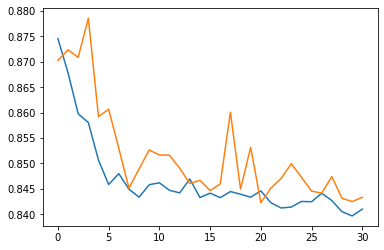

In [11]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

clf = TabNetMultiTaskClassifier(
    n_d=64, n_a=64, n_steps=5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95, "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    device_name='cuda'
)
clf.fit(
    X_train = X_train.values, y_train = np.array(Y_train).reshape(Y_train.shape[0],1),
    eval_set = [(X_val.values, np.array(Y_val).reshape(Y_val.shape[0],1))],     #validation set 지정
    max_epochs=1000,
    patience=30,        # ~20 for early stopping
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False
)
plt.plot(clf.history['loss'][5:])
plt.plot(clf.history['val_0_logloss'][5:])


In [38]:
predict = clf.predict_proba(X_val.values)

In [40]:
predict = pd.DataFrame(np.reshape(np.array(predict), (6615,3)), columns=[0.0, 1.0, 2.0])

In [41]:
y_val_onehot = pd.get_dummies(Y_val)
log_loss(y_val_onehot, predict)

0.8414991948141832

In [42]:
clf.feature_importances_

array([0.        , 0.13454969, 0.00372305, 0.00177471, 0.        ,
       0.0024967 , 0.        , 0.00975541, 0.        , 0.35324094,
       0.        , 0.        , 0.        , 0.011013  , 0.        ,
       0.13670576, 0.34674074])